In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageFilter
from skimage.util import random_noise
import os

In [2]:
2894/(681*731)

0.0058134512897465105

In [3]:
def padding(image):
    row=image.shape[0]
    col=image.shape[1]

    new_image = np.zeros([row+4,col+4],dtype='float')
    for i in range(row+4):
        for j in range(col+4):
            if i==0 or i==row+2 or i==1 or i==row+3:
                new_image[i,j]=0
            elif j==0 or j==col+2 or j==1 or j==col+3:
                new_image[i,j]=0
            else:
                new_image[i,j]=image[i-2,j-2]
    return new_image

In [4]:
def MeanFilter(image,new_image, filter_size):
    row=new_image.shape[0]
    col=new_image.shape[1]
    # create an empty array with same size as input image
    output = np.zeros(image.shape,float)
    # creat an empty variable
    result = 0
    # deal with filter size = 3x3
    if filter_size == 9:
        for i in range(1, row+1):
            for j in range(1,col+1):
                for x in range(-1, 2):
                    for y in range(-1, 2):
                        result = result + new_image[i+x, j+y]
                #print(result)
                output[i][j] =result / filter_size
                result = 0
    elif filter_size == 25:
        for i in range(2,row-2):
            for j in range(2,col-2):
                for y in range(-2, 3):
                    for x in range(-2, 3):
                        result = result + new_image[i+x, j+y]
                output[i-2][j-2] =result/filter_size
                result = 0
    #print(output)
    return output

In [5]:
def MedianFilter(img,image,filter_size):
    # create the kernel array of filter as same size as filter_size
    filter_array = [image[0][0]] * filter_size
    row=image.shape[0]
    col=image.shape[1]
    # create an empty array with same size as input image
    output = np.zeros(img.shape,float)
    if filter_size == 9:
        for j in range(1, image.shape[0]-1):
            for i in range(1, image.shape[1]-1):
                filter_array[0] = image[j-1, i-1]
                filter_array[1] = image[j, i-1]
                filter_array[2] = image[j+1, i-1]
                filter_array[3] = image[j-1, i]
                filter_array[4] = image[j, i]
                filter_array[5] = image[j+1, i]
                filter_array[6] = image[j-1, i+1]
                filter_array[7] = image[j, i+1]
                filter_array[8] = image[j+1, i+1]

                # sort the array
                filter_array.sort()

                # put the median number into output array
                output[j][i] = filter_array[4]

    # deal with filter size = 5x5
    elif filter_size == 25:
        for j in range(2, row-2):
            for i in range(2, col-2):
                filter_array[0] = image[j-2, i-2]
                filter_array[1] = image[j-1, i-2]
                filter_array[2] = image[j, i-2]
                filter_array[3] = image[j+1, i-2]
                filter_array[4] = image[j+2, i-2]
                filter_array[5] = image[j-2, i-1]
                filter_array[6] = image[j-1, i-1]
                filter_array[7] = image[j, i-1]
                filter_array[8] = image[j+1, i-1]
                filter_array[9] = image[j+2, i-1]
                filter_array[10] = image[j-2, i]
                filter_array[11] = image[j-1, i]
                filter_array[12] = image[j, i]
                filter_array[13] = image[j+1, i]
                filter_array[14] = image[j+2, i]
                filter_array[15] = image[j-2, i+1]
                filter_array[16] = image[j-1, i+1]
                filter_array[17] = image[j, i+1]
                filter_array[18] = image[j+1, i+1]
                filter_array[19] = image[j+2, i+1]
                filter_array[20] = image[j-2, i+2]
                filter_array[21] = image[j-1, i+2]
                filter_array[22] = image[j, i+2]
                filter_array[23] = image[j+1, i+2]
                filter_array[24] = image[j+2, i+2]

                # sort the array
                filter_array.sort()

                # put the median number into output array
                output[j-2][i-2] = filter_array[12]
    return output

In [6]:
def koperator(image,new_image,p,q,a):
     
    #dimensions of input image
    row = len(new_image)
    col = len(new_image[0])
    #print(image[0,0])
    #print(new_image)
    
    #now we make a fractional mask using k-opertor of size 3X3
    #we perform masking using p=1 and q=0 and also taking a(alpha) in range(0,2) so we choose a=1
    #for finding these coefficient we also need y1(a) value(given in paper) here for 3X3 filter n=1 and a=1 so a-n=0
    #in this y1(a) function gammma function also given for whose value at 1 = 1 and at 1/2 equals to sqrt(pi)(find these by integral)
    #y1=((-1)**((n-a)/2))*(2**(a-1))*((math.pi)**(n/2))*(math.sqrt(math.pi))
    x=math.pi
    #find  gamma value using gamma function
    g1=math.gamma((2-a)/2)
    #now put these value in y1
    y1=((2**(a))*(x))/g1
    #as giving in paper in Table 2 superposition in all eight direction we need to coffiecient Co and C1
    Co=(p+q)/(2*a*y1)
    C1=((2**(a))*p)/(2*a*y1)
    C2=(p*(2**a-1))/(2*a*y1)
    # create the mask array of filter as same size as filter_size of 9 beacuse 3X3 having size 9
    mask = np.zeros([5,5],dtype='float')
    total=(8*Co)+8*(C1)+8*(C2)
    for i in range(5):
        for j in range(5):
            if i==2 and j==2:
                mask[i][j]=(8*Co)/total
            elif i==0 and j%2==0:
                mask[i][j]=C2/total
            elif i%2==0 and j==0:
                mask[i][j]=C2/total
            elif i==4 and j%2==0:
                mask[i][j]=C2/total
            elif j==4 and i%2==0:
                mask[i][j]=C2/total   
            elif i==0 and j%2==1 or i==4 and j%2==1 or j==0 and i%2==1 or j==4 and i%2==1:
                mask[i][j]=0
            else:
                mask[i][j]=C1/total
            #print(mask[i][j])
    #print(mask)
    #apply Fractional-Mask
    output = np.zeros(image.shape,float)
    result = 0
    #convolution
    for i in range(2,row-2):
            for j in range(2,col-2):
                for x in range(-2, 3):
                    for y in range(-2, 3):
                        result = result + new_image[i+x, j+y]*mask[x+2,y+2]
                output[i-2][j-2] = result
                result = 0
    #print(output)
    return output

In [7]:
def mseerror(finalimg,img):
    error = 0
    row = len(img)
    col = len(img[0])
    for i in range(0,row):
        for j in range(0,col):
            k=img[i,j]-finalimg[i,j] 
            error = error + (k*k)
        #print(error)
    error = error/((row)*(col))
    return error

def psnrerror(mse):
    psnr=20*math.log10(((2**8)-1)/math.sqrt(mse))
    return psnr


In [8]:
def Gauss(image,mean,var):
    #print(image)
    row=image.shape[0]
    col=image.shape[1]
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,image.size)
    gauss = gauss.reshape(row,col)
    #print(gauss)
    #cv2.randu(gauss,mean,sigma)
    image = image + gauss
    #print(image[0,0])
    #plt.imshow(noisy,cmap='gray')
    return image

In [9]:
# a = 0.45
# b = 0.75

# p = 1


#now we make a fractional differential mask of size 5X5


def fracdiff(image, new_image, p, a, m, n):
    
    #find  gamma value using gamma function
    g = math.gamma(2-a)
    
    #the coefficients of the fractional differential mask as provided in research paper 
    C0 = p/g
    C1 = ((p*((2**(1-a))-2)))/g
    C2 = p*((3**(1-a))-(2**(2-a))+1)/g
    
    total = (8*C0)+(8*C1)+(8*C2)
    
    
    # create the mask array of filter as same size as filter_size of 25 beacuse 5X5 having size 25
    mask = np.zeros([5,5],dtype='float')
    for i in range(5):
        for j in range(5):
            if i==2 and j==2:
                mask[i][j]=(8*C0)/total
            elif i==0 and j%2==0:
                mask[i][j]=C2/total
            elif i%2==0 and j==0:
                mask[i][j]=C2/total
            elif i==4 and j%2==0:
                mask[i][j]=C2/total
            elif j==4 and i%2==0:
                mask[i][j]=C2/total   
            elif i==0 and j%2==1 or i==4 and j%2==1 or j==0 and i%2==1 or j==4 and i%2==1:
                mask[i][j]=0
            else:
                mask[i][j]=C1/total
                
                
    # applying fractional differential mask         
    result=0
    for x in range(-2, 3):
        for y in range(-2, 3):
            result = result - new_image[m+x, n+y]*mask[x+2,y+2]
        output[m-2][n-2] = result
       
        result = 0

In [10]:
#now we make a fractional integral mask of size 5X5

def fracint(image, new_image, p, b, m, n):
    
    #find  gamma value using gamma function
    g2 = math.gamma(b)
    
    #the coefficients of the fractional integral mask as provided in research paper
    C0 = p/(2*b*g2)
    C1 = (p*(2**b))/(2*b*g2)
#     C2 = C0*((2**b)-1)
    C2 = p*((3**b)-1)/(2*b*g2)
    
    total = (8*C0)+(8*C1)+(8*C2)
    
    #applying mask
    # create the mask array of filter as same size as filter_size of 25 beacuse 5X5 having size 25
    mask = np.zeros([5,5],dtype='float')
    for i in range(5):
        for j in range(5):
            if i==2 and j==2:
                mask[i][j]=(8*C0)/total
            elif i==0 and j%2==0:
                mask[i][j]=C2/total
            elif i%2==0 and j==0:
                mask[i][j]=C2/total
            elif i==4 and j%2==0:
                mask[i][j]=C2/total
            elif j==4 and i%2==0:
                mask[i][j]=C2/total   
            elif i==0 and j%2==1 or i==4 and j%2==1 or j==0 and i%2==1 or j==4 and i%2==1:
                mask[i][j]=0
            else:
                mask[i][j]=C1/total
    # applying fractional integral mask    
    result=0            
    for x in range(-2, 3):
        for y in range(-2, 3):
            result = result + new_image[m+x, n+y]*mask[x+2,y+2]
        output[m-2][n-2] = result
        
        result = 0


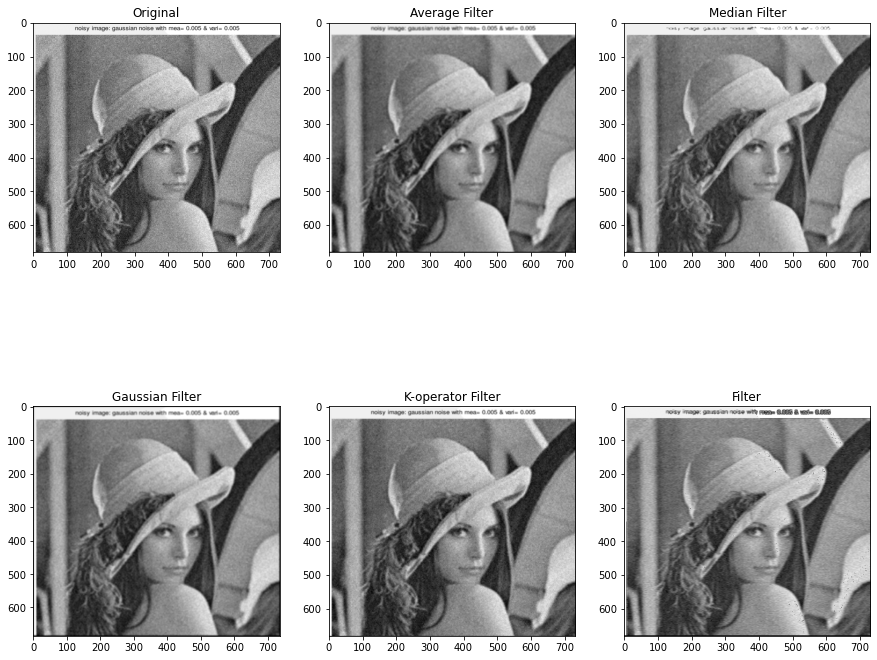

In [11]:
if __name__ == '__main__':
    
    #import image
    im = cv2.imread('lena.png' ,cv2.IMREAD_GRAYSCALE)
    
    #add padding
    gray_im = padding(im)
    
    #define row as number of rows and col as number of columns
    row = len(im)
    col = len(im[0])
#     print(im[0, 0])
#     print(row)
#     print(col)
    
    
    #selection of noisy pixels
     
    
    z = np.zeros([row,col], dtype='float')
    
#     e=0
    for i in range(2,row-2):
        for j in range(2,col-2):
            if im[i, j]>0 and im[i, j]<255:              
                pass
            elif (im[i, j]==0 or im[i, j]==255):
                c=0
                d=0
                flag=0
                for p in range(i-1,i+2):
                    for q in range(j-1,j+2):
                        if im[p, q]==0 or im[p, q]==255:
                            c=c+1
                        elif im[p, q]<10 or im[p, q]>245:
                            flag=1
#                             break
                        else:
                            d=d+1
#                     if flag==1:
#                         break
                   
                if d>0 and flag==0:
                    z[i, j]=1
#                 if flag==1:
#                     break  
                if c==8 or flag==1:
                    c=0
                    d=0
                    flag=0
                    for p in range(i-2,i+3):
                        for q in range(j-2,j+3):
                            if im[p, q]==0 or im[p,q]==255:
                                c=c+1
                            elif im[p, q]<10 or im[p, q]>245:
                                flag=1  
#                                 break
                            else:
                                d=d+1
                                
#                         if flag==1:
#                             break
                            
                            
                    if d>0 and flag==0:
                        z[i, j]=1
#                     if flag==1:
#                         break
                    if c==16 or flag==1:
                        c=0
                        d=0
                        flag=0
                        for p in range(i-3,i+4):
                            for q in range(j-3,j+4):
                                if im[p, q]==0 or im[p,q]==255:
                                    c=c+1
                                elif im[p, q]<10 or im[p, q]>245:
                                    flag=1  
                                    break
                                else:
                                    d=d+1
                                    
                            if d>0 and flag==0:
                                z[i, j]=1
                            if flag==1:
                                break
                                
       
    output = np.zeros(im.shape, dtype='float')
   
    
    for i in range(2, row+2):
         for j in range(2, col+2):
                
                # if the pixel is not noisy apply fractional differential mask 
                if z[i-2][j-2]==0:
                    fracdiff(im, gray_im, 1.02, 2.45, i, j)
                    
                # if the pixel is noisy apply fractional integral mask 
                else:
                    fracint(im, gray_im, 1.02, 0.75, i, j)
                    
    
    # calling functions by passing respective noisy image
    finalimgAvg = MeanFilter(im, gray_im, 25)
    finalimgMed = MedianFilter(im, gray_im, 25)
    finalimgGau = cv2.GaussianBlur(gray_im,(5,5),cv2.BORDER_DEFAULT)
    finalimgKop = koperator(im, gray_im,1.05,0,1.04)
    
    #print(psnr)
    #plt.imshow(img,cmap='gray')
    
    fig = plt.figure()
    fig.set_figheight(20)
    fig.set_figwidth(15)
        
    # display the oringinal image
    
    fig.add_subplot(3, 3, 1)
    plt.title('Original')                
    plt.imshow(im, cmap='gray')   
    
    # display the salt and paper image
    
    fig.add_subplot(3, 3, 2)
    plt.title('Average Filter')
    plt.imshow(finalimgAvg, cmap='gray')
    
    fig.add_subplot(3, 3, 3)
    plt.title('Median Filter')
    plt.imshow(finalimgMed, cmap='gray')
    
    fig.add_subplot(3, 3, 4)
    plt.title('Gaussian Filter')
    plt.imshow(finalimgGau, cmap='gray')
    
    fig.add_subplot(3, 3, 5)
    plt.title('K-operator Filter')
    plt.imshow(finalimgKop, cmap='gray')
    
    fig.add_subplot(3, 3, 6)
    plt.title('Filter')
    plt.imshow(output, cmap='gray')
    
    
    
    # counting mseerror
#     a=mseerror(finalimgAvg,im)
#     b=mseerror(finalimgMed,im)
#     c=mseerror(finalimgGau,im)
#     d=mseerror(finalimgKop,im)
#     e=mseerror(output,im)
    
#     print(a,b,c,d,e)
#     print(psnrerror(a),psnrerror(b),psnrerror(c),psnrerror(d),psnrerror(e))
    
    
    
#     output.show()
#     plt.imshow(z, cmap='gray')

   
    
    
                
            
                    
    
                    
            
                    
    
                        
    
        
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
#     gray1=img+noised
#     cv2.imshow('bhabhi', noised)
#     cv2.imshow('bhabhi', im)
    
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()